## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## Information about Author (Student)
- Name: Gabriel dos Santos Gonçalves
- Email: gabrielgoncalvesbr@gmail.com
- Github: GabrielSGoncalves

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

# for visualizing each feature distribution
import klib

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../../datasets/house-prices-advanced-regression-techniques/train.csv')

In [3]:
data

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [4]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [5]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [6]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [7]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [8]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Visual inspection of features
On this session I'm going to use klib to evaluate some characteristics of each feature from the dataset using the library `klib`. <br>
More information about it in the link below:
* https://github.com/akanz1/klib

```python

klib.missingval_plot(X_train)

klib.corr_plot(X_train, split='pos')

klib.dist_plot(X_train, showall=True)

klib.cat_plot(X_train.iloc[:,:15], top=4, bottom=4)
```

In [9]:
import plotly.graph_objects as go

In [10]:
X_train[X_train.MSSubClass.notnull()].MSSubClass

930      20
656      20
45      120
1348     20
55       20
       ... 
763      60
835      20
1216     90
559     120
684      60
Name: MSSubClass, Length: 1314, dtype: int64

In [11]:
#help(go.Histogram())

## Feature Engineering Pipeline

In [12]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [13]:
data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].dtypes

LotFrontage    float64
MasVnrArea     float64
GarageYrBlt    float64
dtype: object

In [14]:
data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']]

LotFrontage  MasVnrArea  GarageYrBlt
0            65.0       196.0       2003.0
1            80.0         0.0       1976.0
2            68.0       162.0       2001.0
3            60.0         0.0       1998.0
4            84.0       350.0       2000.0
...           ...         ...          ...
1455         62.0         0.0       1999.0
1456         85.0       119.0       1978.0
1457         66.0         0.0       1941.0
1458         68.0         0.0       1950.0
1459         75.0         0.0       1965.0

[1460 rows x 3 columns]

In [15]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddMissingIndicator(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=6,
                                    variables=categorical + discrete)),
    ('categorical_enc',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=categorical + discrete)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=numerical)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [16]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/gabriel/miniconda3/envs/basic/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories 

In [17]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 1035269885.2749027
train rmse: 32175.610099497768
train r2: 0.834193183650799

test mse: 2006905385.1371982
test rmse: 44798.49757678485
test r2: 0.7079639526659388


Text(0, 0.5, 'Predicted Price')

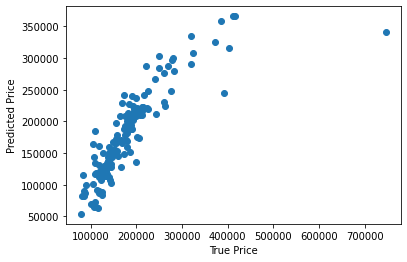

In [18]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

<AxesSubplot:>

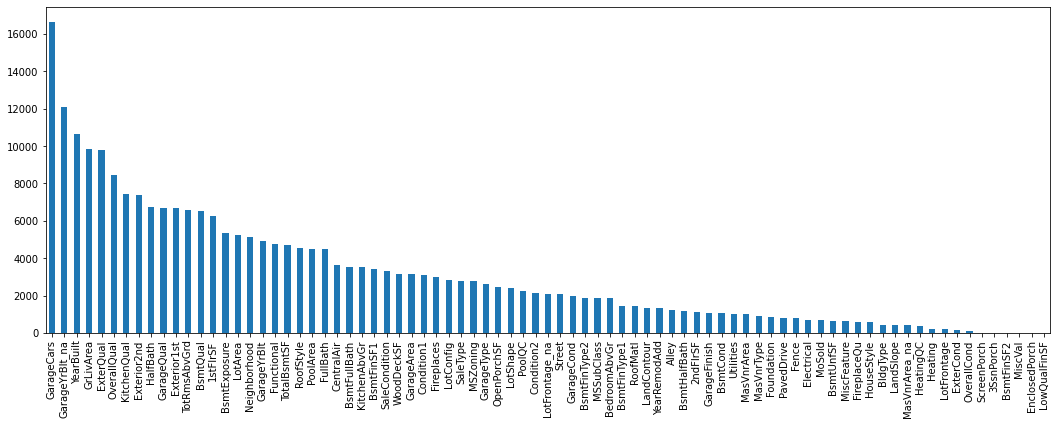

In [19]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))

## Creating a class to visualize features

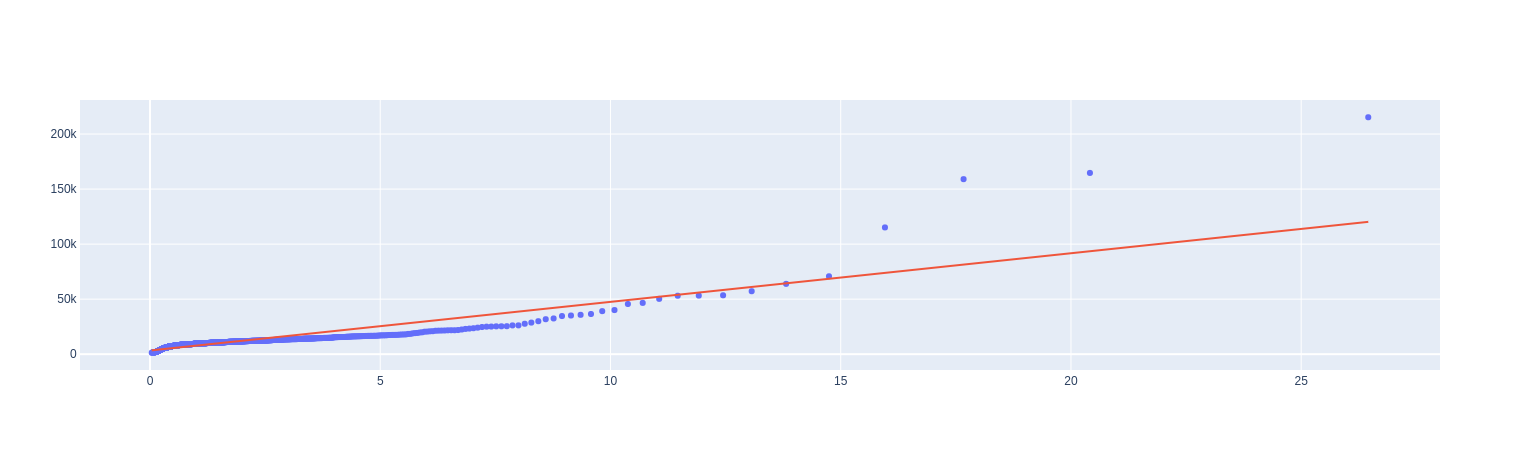

In [20]:
import numpy as np
from scipy import stats
import plotly.graph_objects as go
#X_lognorm = np.random.lognormal(mean=0.0, sigma=1.7, size=500)

qq = stats.probplot(X_train.LotArea, dist='lognorm', sparams=(1))
x = np.array([qq[0][0][0], qq[0][0][-1]])

fig = go.Figure()
fig.add_scatter(x=qq[0][0], y=qq[0][1], mode='markers')
fig.add_scatter(x=x, y=qq[1][1] + qq[1][0]*x, mode='lines')
fig.layout.update(showlegend=False)
fig.show()

In [21]:
import numpy as np
from scipy import stats

def get_qqplot_trace(dataframe, column):
    qq = stats.probplot(dataframe[column], dist='lognorm', sparams=(1))
    x = np.array([qq[0][0][0], qq[0][0][-1]])
    
    trace_markers = go.Scatter(x=qq[0][0], y=qq[0][1], mode='markers')
    trace_line = go.Scatter(x=x, y=qq[1][1] + qq[1][0]*x, mode='lines')
    return trace_markers, trace_line
    

## Testing `FeatureExplorer`

In [22]:
from feature_explorer import FeatureExplorer, _transform_feature, _get_histogram_trace

In [23]:
histobj = _get_histogram_trace(X_train, '1stFlrSF')

In [24]:
histobj.__dict__

{'_skip_invalid': False,
 '_validate': True,
 '_plotly_name': 'histogram',
 '_compound_props': {},
 '_compound_array_props': {},
 '_orphan_props': {'x': array([1466, 1053, 1752, ..., 1318, 1557, 1195]),
  'type': 'histogram'},
 '_parent': None,
 '_change_callbacks': {},
 '_BasePlotlyType__validators': None,
 '_hover_callbacks': [],
 '_unhover_callbacks': [],
 '_click_callbacks': [],
 '_select_callbacks': [],
 '_deselect_callbacks': [],
 '_trace_ind': None}

In [25]:
X_train.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscFeature       object
MiscVal            int64
MoSold            object
SaleType          object
SaleCondition     object
Length: 78, dtype: object

In [26]:
X_train.select_dtypes(include='number')

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
930          73.0     8925          2             2         0.0          16   
656          72.0    10007         49             2        54.0         806   
45           61.0     7658          5             5       412.0         456   
1348          NaN    16196          9             9         0.0        1443   
55          100.0    10175         44            44       272.0         490   
...           ...      ...        ...           ...         ...         ...   
763          82.0     9430         10            10       673.0        1163   
835          60.0     9600         60            15         0.0         442   
1216         68.0     8930         32            32         0.0           0   
559           NaN     3196          3             2        18.0           0   
684          58.0    16770         12            12        30.0           0   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  LowQualFinSF  \
930            0       1450         1466      1466  ...             0   
656            0        247         1053      1053  ...             0   
45             0       1296         1752      1752  ...             0   
1348           0         39         1482      1494  ...             0   
55             0        935         1425      1425  ...             0   
...          ...        ...          ...       ...  ...           ...   
763            0         89         1252      1268  ...             0   
835            0        625         1067      1067  ...             0   
1216           0          0            0      1318  ...             0   
559            0       1374         1374      1557  ...             0   
684            0       1195         1195      1195  ...             0   

      GrLivArea  GarageYrBlt  GarageArea  WoodDeckSF  OpenPorchSF  \
930        1466          2.0         610         100           18   
656        1053         49.0         312           0            0   
45         1752          5.0         576         196           82   
1348       1494          9.0         514         402           25   
55         1425         44.0         576           0            0   
...         ...          ...         ...         ...          ...   
763        2365         10.0         856           0          128   
835        1067         14.0         436         290            0   
1216       1902         32.0         539           0            0   
559        1557          3.0         420         143           20   
684        1839         12.0         486           0           81   

      EnclosedPorch  3SsnPorch  ScreenPorch  MiscVal  
930               0          0            0        0  
656               0          0            0        0  
45                0          0            0        0  
1348              0          0            0        0  
55                0        407            0        0  
...             ...        ...          ...      ...  
763               0          0          180        0  
835               0          0            0        0  
1216              0          0            0        0  
559               0          0            0        0  
684               0          0            0        0  

[1314 rows x 21 columns]

In [27]:
feat_explorer = FeatureExplorer(X_train, {})

In [28]:
X_train.GrLivArea.kurtosis().round(2)

4.76

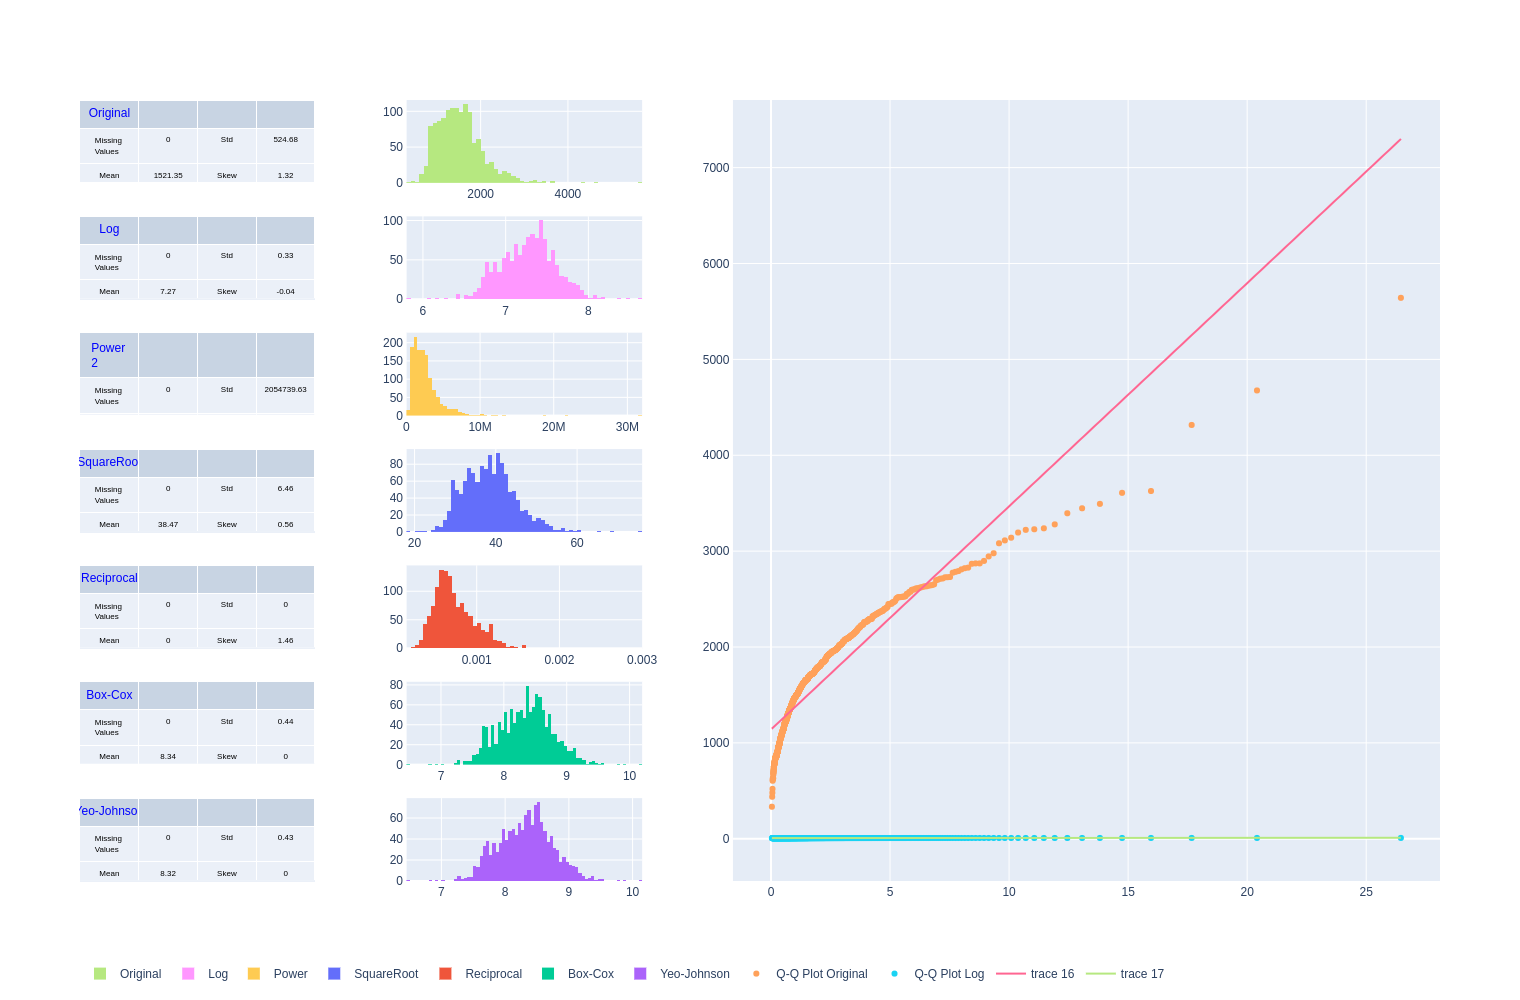

In [29]:
feat_explorer.plot_feature_info('GrLivArea', plot_size=(1200,1000))

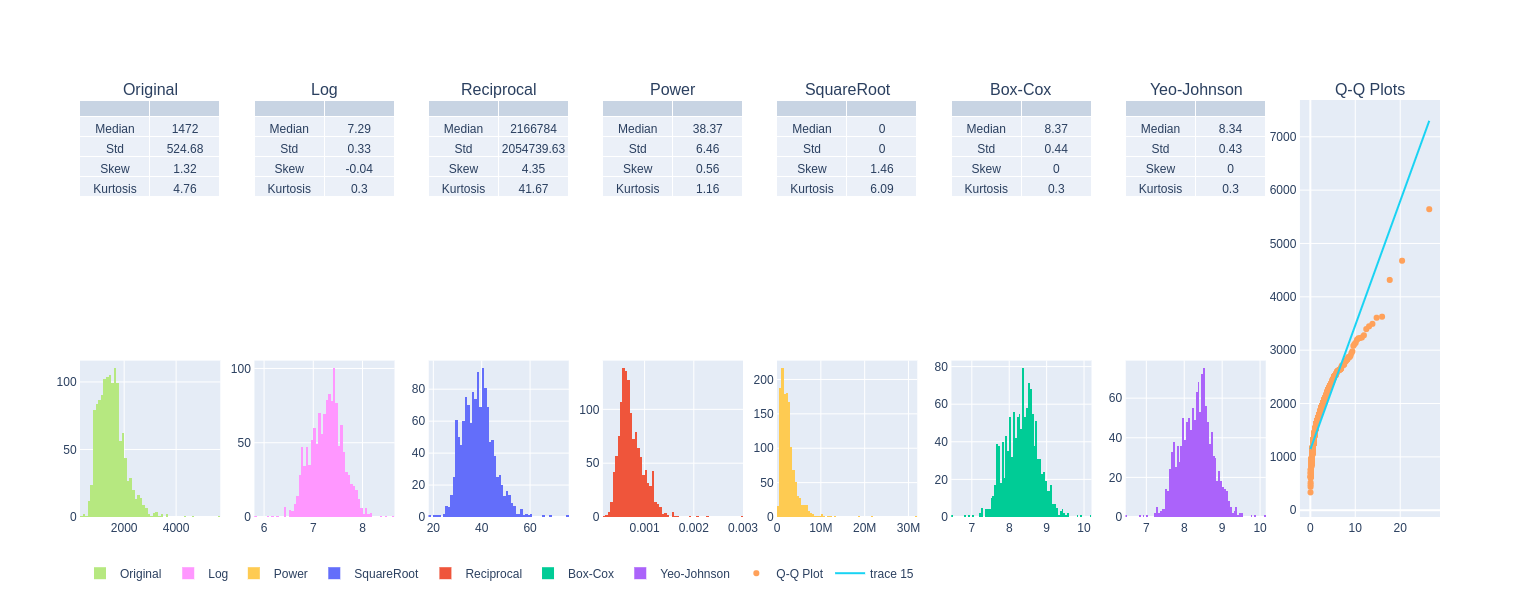

In [30]:
feat_explorer.plot_feature_info('GrLivArea', plot_size=(1200,600))

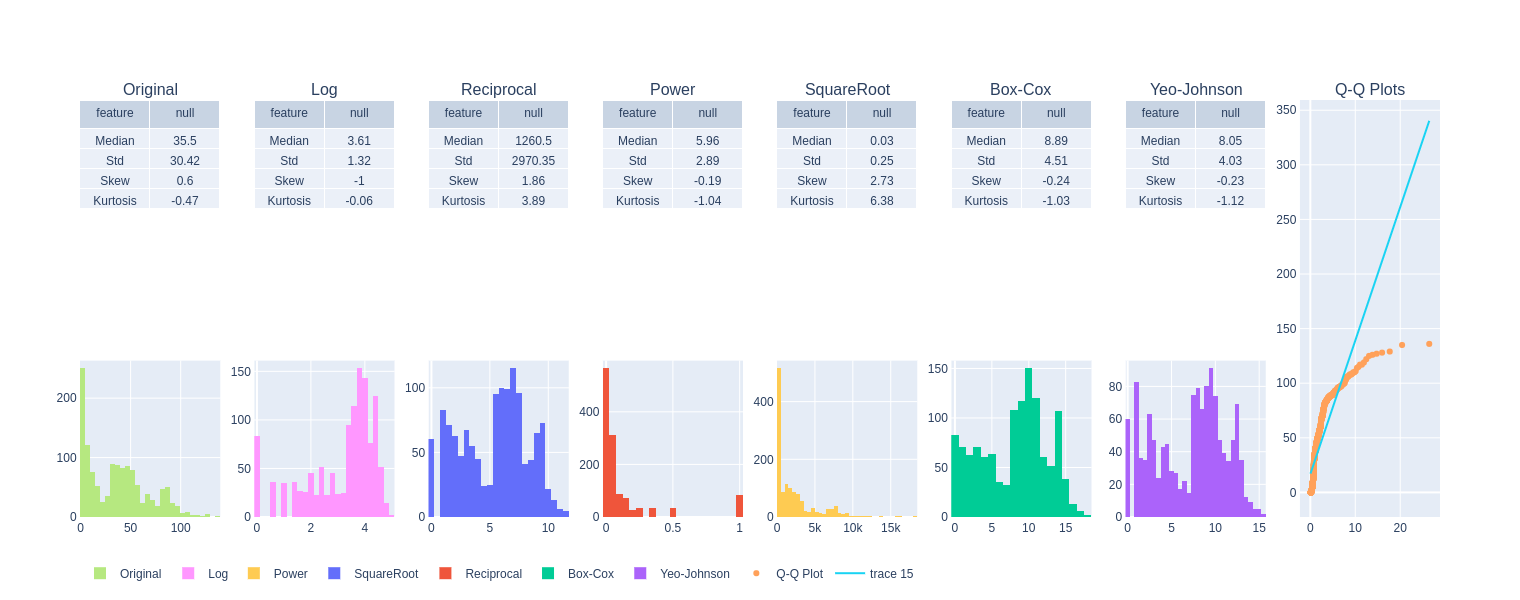

In [33]:
feat_explorer.plot_feature_info('YearBuilt', plot_size=(1200,600))

In [29]:
X_train.select_dtypes(include='number')

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
930          73.0     8925          2             2         0.0          16   
656          72.0    10007         49             2        54.0         806   
45           61.0     7658          5             5       412.0         456   
1348          NaN    16196          9             9         0.0        1443   
55          100.0    10175         44            44       272.0         490   
...           ...      ...        ...           ...         ...         ...   
763          82.0     9430         10            10       673.0        1163   
835          60.0     9600         60            15         0.0         442   
1216         68.0     8930         32            32         0.0           0   
559           NaN     3196          3             2        18.0           0   
684          58.0    16770         12            12        30.0           0   

      BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  LowQualFinSF  \
930            0       1450         1466      1466  ...             0   
656            0        247         1053      1053  ...             0   
45             0       1296         1752      1752  ...             0   
1348           0         39         1482      1494  ...             0   
55             0        935         1425      1425  ...             0   
...          ...        ...          ...       ...  ...           ...   
763            0         89         1252      1268  ...             0   
835            0        625         1067      1067  ...             0   
1216           0          0            0      1318  ...             0   
559            0       1374         1374      1557  ...             0   
684            0       1195         1195      1195  ...             0   

      GrLivArea  GarageYrBlt  GarageArea  WoodDeckSF  OpenPorchSF  \
930        1466          2.0         610         100           18   
656        1053         49.0         312           0            0   
45         1752          5.0         576         196           82   
1348       1494          9.0         514         402           25   
55         1425         44.0         576           0            0   
...         ...          ...         ...         ...          ...   
763        2365         10.0         856           0          128   
835        1067         14.0         436         290            0   
1216       1902         32.0         539           0            0   
559        1557          3.0         420         143           20   
684        1839         12.0         486           0           81   

      EnclosedPorch  3SsnPorch  ScreenPorch  MiscVal  
930               0          0            0        0  
656               0          0            0        0  
45                0          0            0        0  
1348              0          0            0        0  
55                0        407            0        0  
...             ...        ...          ...      ...  
763               0          0          180        0  
835               0          0            0        0  
1216              0          0            0        0  
559               0          0            0        0  
684               0          0            0        0  

[1314 rows x 21 columns]

In [30]:
X_train.MoSold.dtypes

dtype('O')